In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from joblib import Parallel, delayed

In [2]:
def get_R(u, v):
    assert len(u) == len(v)
    
    d= len(u)
    
    sum_ = u+v
    sum_ = sum_[:, np.newaxis]
    num = sum_ @ sum_.T
    den = sum_.T @ sum_
    
    R = 2 * (num / den) - np.eye(d)
    
    return R

In [3]:
u = np.array([0,1])
v= np.array([1,0])

R = get_R(u,v)

R @ u

array([1., 0.])

In [4]:
from sklearn.metrics import balanced_accuracy_score as bas

def FLD_experiment(n=10, m=20, d=2, T=2, k=100):
    mean = np.zeros(d)
    mean[0] = 1
            
    vmf = tfp.distributions.VonMisesFisher(mean, k)
    dir_vectors = np.array(vmf.sample(T))
    
    R_list = [get_R(mean, dir_vec) for dir_vec in dir_vectors]
    
    means = [mean @ R for R in R_list]
    
    ldas = []
    
    n0 = n // 2
    n1 = n - n0
    
    I = np.eye(d)
        
    X = np.vstack([np.random.multivariate_normal(means[0], I, size=n0), 
                        np.random.multivariate_normal(-1 * means[0], I, size=n1)
                       ])
    y = np.hstack([np.zeros(n0), np.ones(n1)])
    
    lda = LDA()
    lda.fit(X,y)
    ldas.append(lda)
    
    del X, y
        
    m0 = m // 2
    m1 = m - m0
    for i, mean in enumerate(means[1:]):
        

        X = np.vstack([np.random.multivariate_normal(mean, I, size=m0), 
                            np.random.multivariate_normal(-1 * mean, I, size=m1)
                           ])
        y = np.hstack([np.zeros(m0), np.ones(m1)])
        
        lda = LDA()
        lda.fit(X,y)
        ldas.append(lda)

        del X, y
        
    accuracies = np.zeros(3)
    
    X = np.vstack([np.random.multivariate_normal(means[0], I, size=1000), 
                        np.random.multivariate_normal(-1 * means[0], I, size=1000)
                       ])
    y = np.hstack([np.zeros(1000), np.ones(1000)])
    
    in_posteriors = ldas[0].predict_proba(X)
    accuracies[0] = bas(y, np.argmax(in_posteriors, axis=1))
    
    all_out_posteriors = np.zeros((T-1, 2*1000, 2))
    for j, lda in enumerate(ldas[1:]):
        all_out_posteriors[j] = lda.predict_proba(X)
        
    out_posteriors = np.mean(all_out_posteriors, axis=0)
    accuracies[1] = bas(y, np.argmax(out_posteriors, axis=1))
    
    oracle_alpha = 0
    oracle_acc = accuracies[1]
    for alpha in np.arange(0.001, 1.001, step=0.001):
        posteriors = np.average([in_posteriors, out_posteriors], weights=[alpha, 1-alpha], axis=0)
        
        acc = bas(y, np.argmax(posteriors, axis=1))
        
        if acc > oracle_acc:
            oracle_alpha=alpha
            oracle_acc=acc
            
    accuracies[2] = oracle_acc
    
    return accuracies

In [137]:
from tqdm import tqdm
np.random.seed(1)

m=20
d=2

n_list=np.array([10,20,40])
T_list= np.array([2,6,21])
k_list = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])

n_mc=1000
n_jobs=30

accuracies = np.zeros((len(n_list), len(T_list), len(k_list), 3, n_mc))

for i, n in enumerate(tqdm(n_list)):
    for j, T in enumerate(T_list):
        for kk, k in enumerate(k_list):
            f = lambda x: FLD_experiment(n,m,d,T,k)

            accuracies[i,j,kk] = np.array(Parallel(n_jobs=n_jobs)(delayed(f)(x) for x in np.zeros(n_mc))).T

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]2022-07-13 21:48:01.269634: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-13 21:48:01.276770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 21:48:01.277110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-13 21:48:01.305016: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from differen

2022-07-13 21:48:01.764057: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-13 21:48:01.770304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 21:48:01.783651: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-13 21:48:01.817408: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-13 21:48:01.8287

2022-07-13 21:48:04.333050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 21:48:04.333557: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 21:48:04.333766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2022-07-13 21:48:04.334340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 21:48:04.727699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

2022-07-13 21:48:06.433060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 21:48:06.447668: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 21:48:06.447907: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2022-07-13 21:48:06.448323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 21:48:06.526465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

2022-07-13 21:48:07.151360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 21:48:07.154635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 21:48:07.155066: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 21:48:07.155261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2022-07-13 21:48:07.155864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

/tmp/ipykernel_4063166/518256174.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


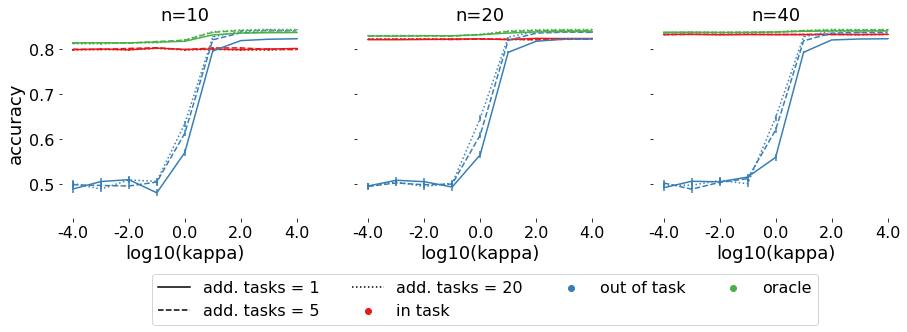

In [143]:
fig, axes = plt.subplots(1,3, figsize=(15,7), sharey=True, sharex=True)
algos = ['in task', 'out of task', 'oracle']
colors = sns.color_palette("Set1", n_colors=len(algos))

ls = ['-', '--',':', '-.']

for i, T in enumerate(T_list):
    axes[0].axhline(y=0, c='k', ls=ls[i], label='add. tasks = %i'%(T-1))

for j in range(len(algos)):
    axes[0].scatter([1],[0], color=colors[j], label=algos[j])
    
axes[0].set_ylabel('accuracy', fontsize=18)



for i, ax in enumerate(axes):
    mean_accuracies = np.mean(accuracies[i], axis=-1)
    std_accuracies = np.std(accuracies[i], axis=-1) / np.sqrt(n_mc)
    n = n_list[i]
    
    

#     ax.set_xscale('log')


    for j, mean_by_algo in enumerate(mean_accuracies.T):
    #     print(mean_by_algo.shape)
        
        for k, mean in enumerate(mean_by_algo.T):
            std_ = std_accuracies.T[j].T[k]
            
            

            ax.errorbar(np.log10(k_list), mean, yerr=std_, color=colors[j], ls=ls[k])
            
    ax.set_title('n=%i'%(n), fontsize=18)
    ax.set_xlabel('log10(kappa)', fontsize=18)
    ax.tick_params(labelsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

plt.subplots_adjust(bottom=0.5)
axes[0].legend(loc='lower left', fontsize=16, bbox_to_anchor=(1/3, -0.6), ncol=4)

    
    
ax.set_xticks(np.log10(k_list[::2]))
ax.set_xticklabels(np.log10(k_list[::2]))

ax.set_yticks([0.5, 0.6, 0.7, 0.8])

ax.set_ylim(0.425, 0.85)

plt.tight_layout()
plt.savefig(fname='changing_kappa.png', dpi=500)

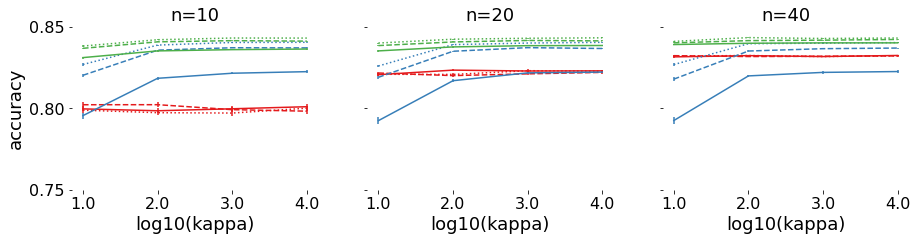

In [144]:
fig, axes = plt.subplots(1,3, figsize=(15,3), sharey=True, sharex=True)
ls = ['-', '--',':', '-.']

for i, T in enumerate(T_list):
    axes[0].axhline(y=0, c='k', ls=ls[i], label='add. tasks = %i'%(T-1))

for j in range(len(algos)):
    axes[0].scatter([1],[0], color=colors[j], label=algos[j])
    
# axes[0].legend(loc='upper left', fontsize=16, bbox_to_anchor=(1/3, -0.18), ncol=4)
axes[0].set_ylabel('accuracy', fontsize=18)


for i, ax in enumerate(axes):
    mean_accuracies = np.mean(accuracies[i], axis=-1)
    std_accuracies = np.std(accuracies[i], axis=-1) / np.sqrt(n_mc)
    n = n_list[i]
    
#     ax.set_xscale('log')

    for j, mean_by_algo in enumerate(mean_accuracies.T):
    #     print(mean_by_algo.shape)
        
        for k, mean in enumerate(mean_by_algo.T):
            std_ = std_accuracies.T[j].T[k]

            ax.errorbar(np.log10(k_list[5:]), mean[5:], yerr=std_[5:], color=colors[j], ls=ls[k])
            
    ax.set_title('n=%i'%(n), fontsize=18)
    ax.set_xlabel('log10(kappa)', fontsize=18)
    ax.tick_params(labelsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
ax.set_xticks((np.log10(k_list[5:])))
ax.set_xticklabels(np.log10(k_list[5:]))

ax.set_yticks([0.75, 0.8, 0.85])

ax.set_ylim(0.75, 0.85)

# plt.tight_layout()
plt.savefig(fname='changing_kappa_zoomed.png', dpi=500)